In [1]:
import torch
from torch import nn
import torch.nn.functional as F


class My_Encoder(nn.Module):
    def __init__(self, dim, dim_encoder_output, activation="tanh"):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(784, dim)
        self.l1 = nn.Linear(dim, dim)
        self.l2 = nn.Linear(dim, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim, dim_decoder_input, activation="tanh"):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, dim)
        self.l1 = nn.Linear(dim, dim)
        self.l2 = nn.Linear(dim, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm import tqdm
from celluloid import Camera

from collections import OrderedDict

import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [48]:
x_ori = training_data.data / training_data.data.max().to(torch.float)
x_ori.max()

tensor(1.)

In [14]:
x_idx = torch.arange(0, len(x)).to(torch.long)
x_idx.shape

torch.Size([60000])

In [18]:
class CustomImageDataset(Dataset):
    def __init__(self, x):
        self.x = x.view(-1, 1, 28, 28)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], idx

dataloader = DataLoader(CustomImageDataset(x), batch_size=128, shuffle=True)

In [119]:
model = nn.Sequential(
    OrderedDict(
        [
            ("encoder", My_Encoder(512, 4)),
            ("decoder", My_Decoder(512, 2)),
        ]
    )
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

device = 'cpu'

for _ in tqdm(range(10)):
    for x, idx in dataloader:

        h = model.get_submodule("encoder")(x)
        mu = h[:, :2]
        log_sigma = h[:, 2:4]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu, device=device) * sigma + mu
        pred = model.get_submodule("decoder")(z)
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='none')
        loss = ll.sum() / len(x) + kl

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


In [106]:
x_idx.shape

torch.Size([60000])

In [120]:
model.eval()

with torch.no_grad():
    h = model.get_submodule("encoder")(x_ori)
    mu = h[:, :2]
    pred = model.get_submodule("decoder")(mu)
    ll = F.binary_cross_entropy(pred.view(-1, 28, 28), x_ori, reduction='none').sum(dim=[1, 2])

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = x_idx[n_ll > 3]
    print(outliers.shape)

torch.Size([61])


In [111]:
def show_images(images, indices):
    nr = len(indices) // 10 + 1
    imgs = images[indices]
    imgs = torch.cat([imgs, torch.ones(nr * 10 - len(imgs), 28, 28)])

    _, axs = plt.subplots(nr, 10, figsize=[20, 2 * nr])
    
    for ax, img in zip(axs.flat, imgs):
        ax.imshow(img, cmap='gray', vmax=1, vmin=0)
        ax.axis('off')
    plt.tight_layout()


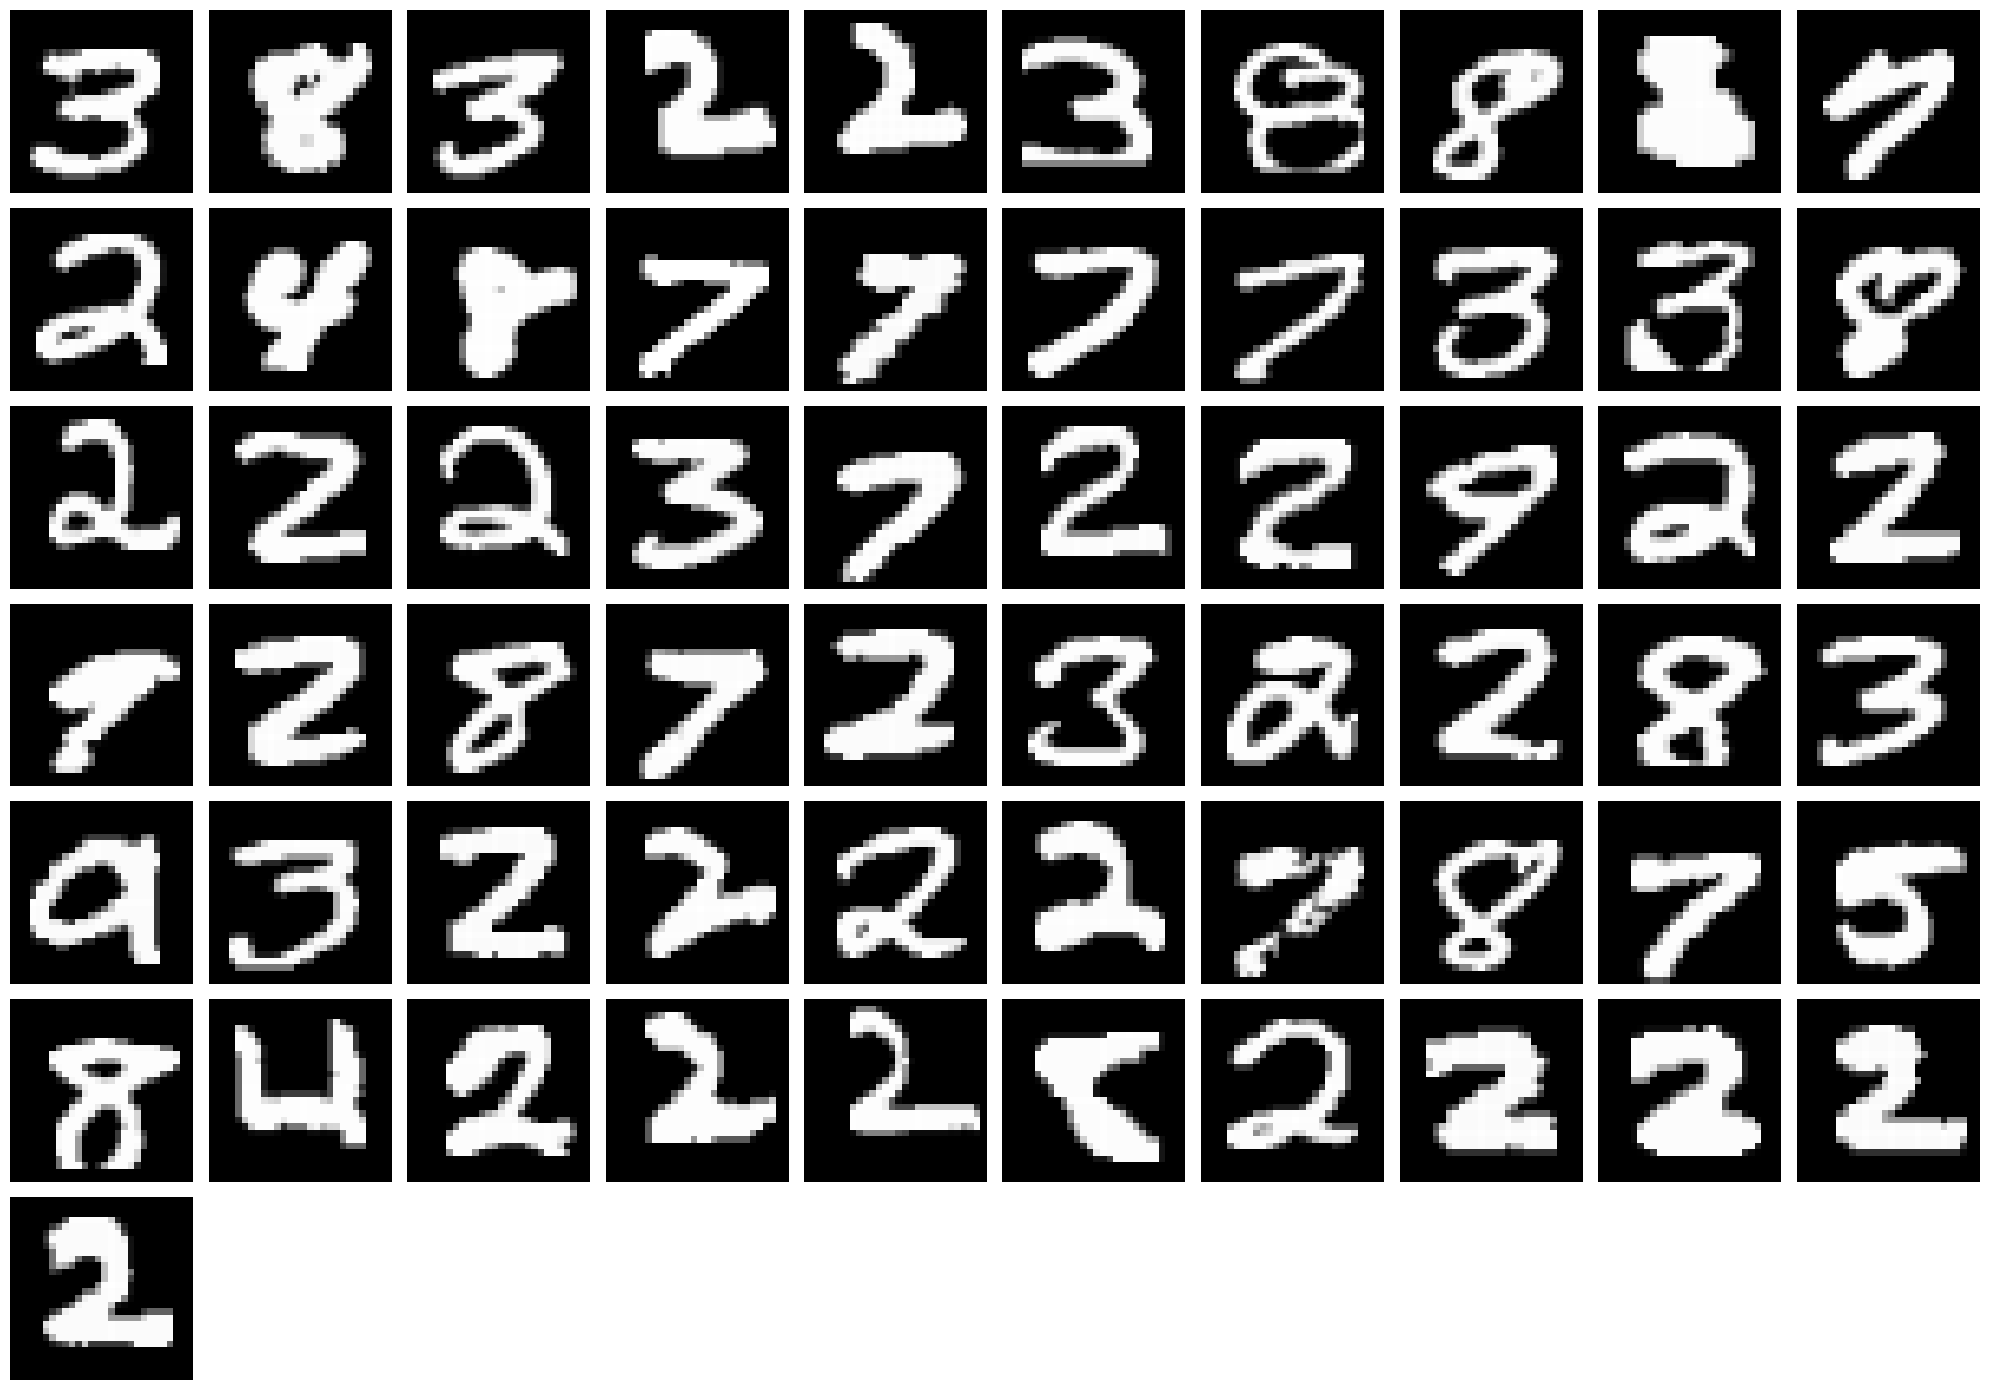

In [121]:
show_images(x_ori, outliers)

In [122]:
x_idx_new = torch.tensor([e for e in x_idx if e not in outliers], dtype=torch.long)
x_new = x_ori[x_idx_new]
dataloader = DataLoader(CustomImageDataset(x_new), batch_size=128, shuffle=True)

In [123]:
for _ in tqdm(range(10)):
    for x, idx in dataloader:

        h = model.get_submodule("encoder")(x)
        mu = h[:, :2]
        log_sigma = h[:, 2:4]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu, device=device) * sigma + mu
        pred = model.get_submodule("decoder")(z)
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='none')
        loss = ll.sum() / len(x) + kl

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


In [124]:
model.eval()

x_idx_new = torch.arange(0, len(x_new)).to(torch.long)

with torch.no_grad():
    h = model.get_submodule("encoder")(x_new)
    mu = h[:, :2]
    pred = model.get_submodule("decoder")(mu)
    ll = F.binary_cross_entropy(pred.view(-1, 28, 28), x_new, reduction='none').sum(dim=[1, 2])

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = x_idx_new[n_ll > 3]
    print(outliers.shape)

torch.Size([93])


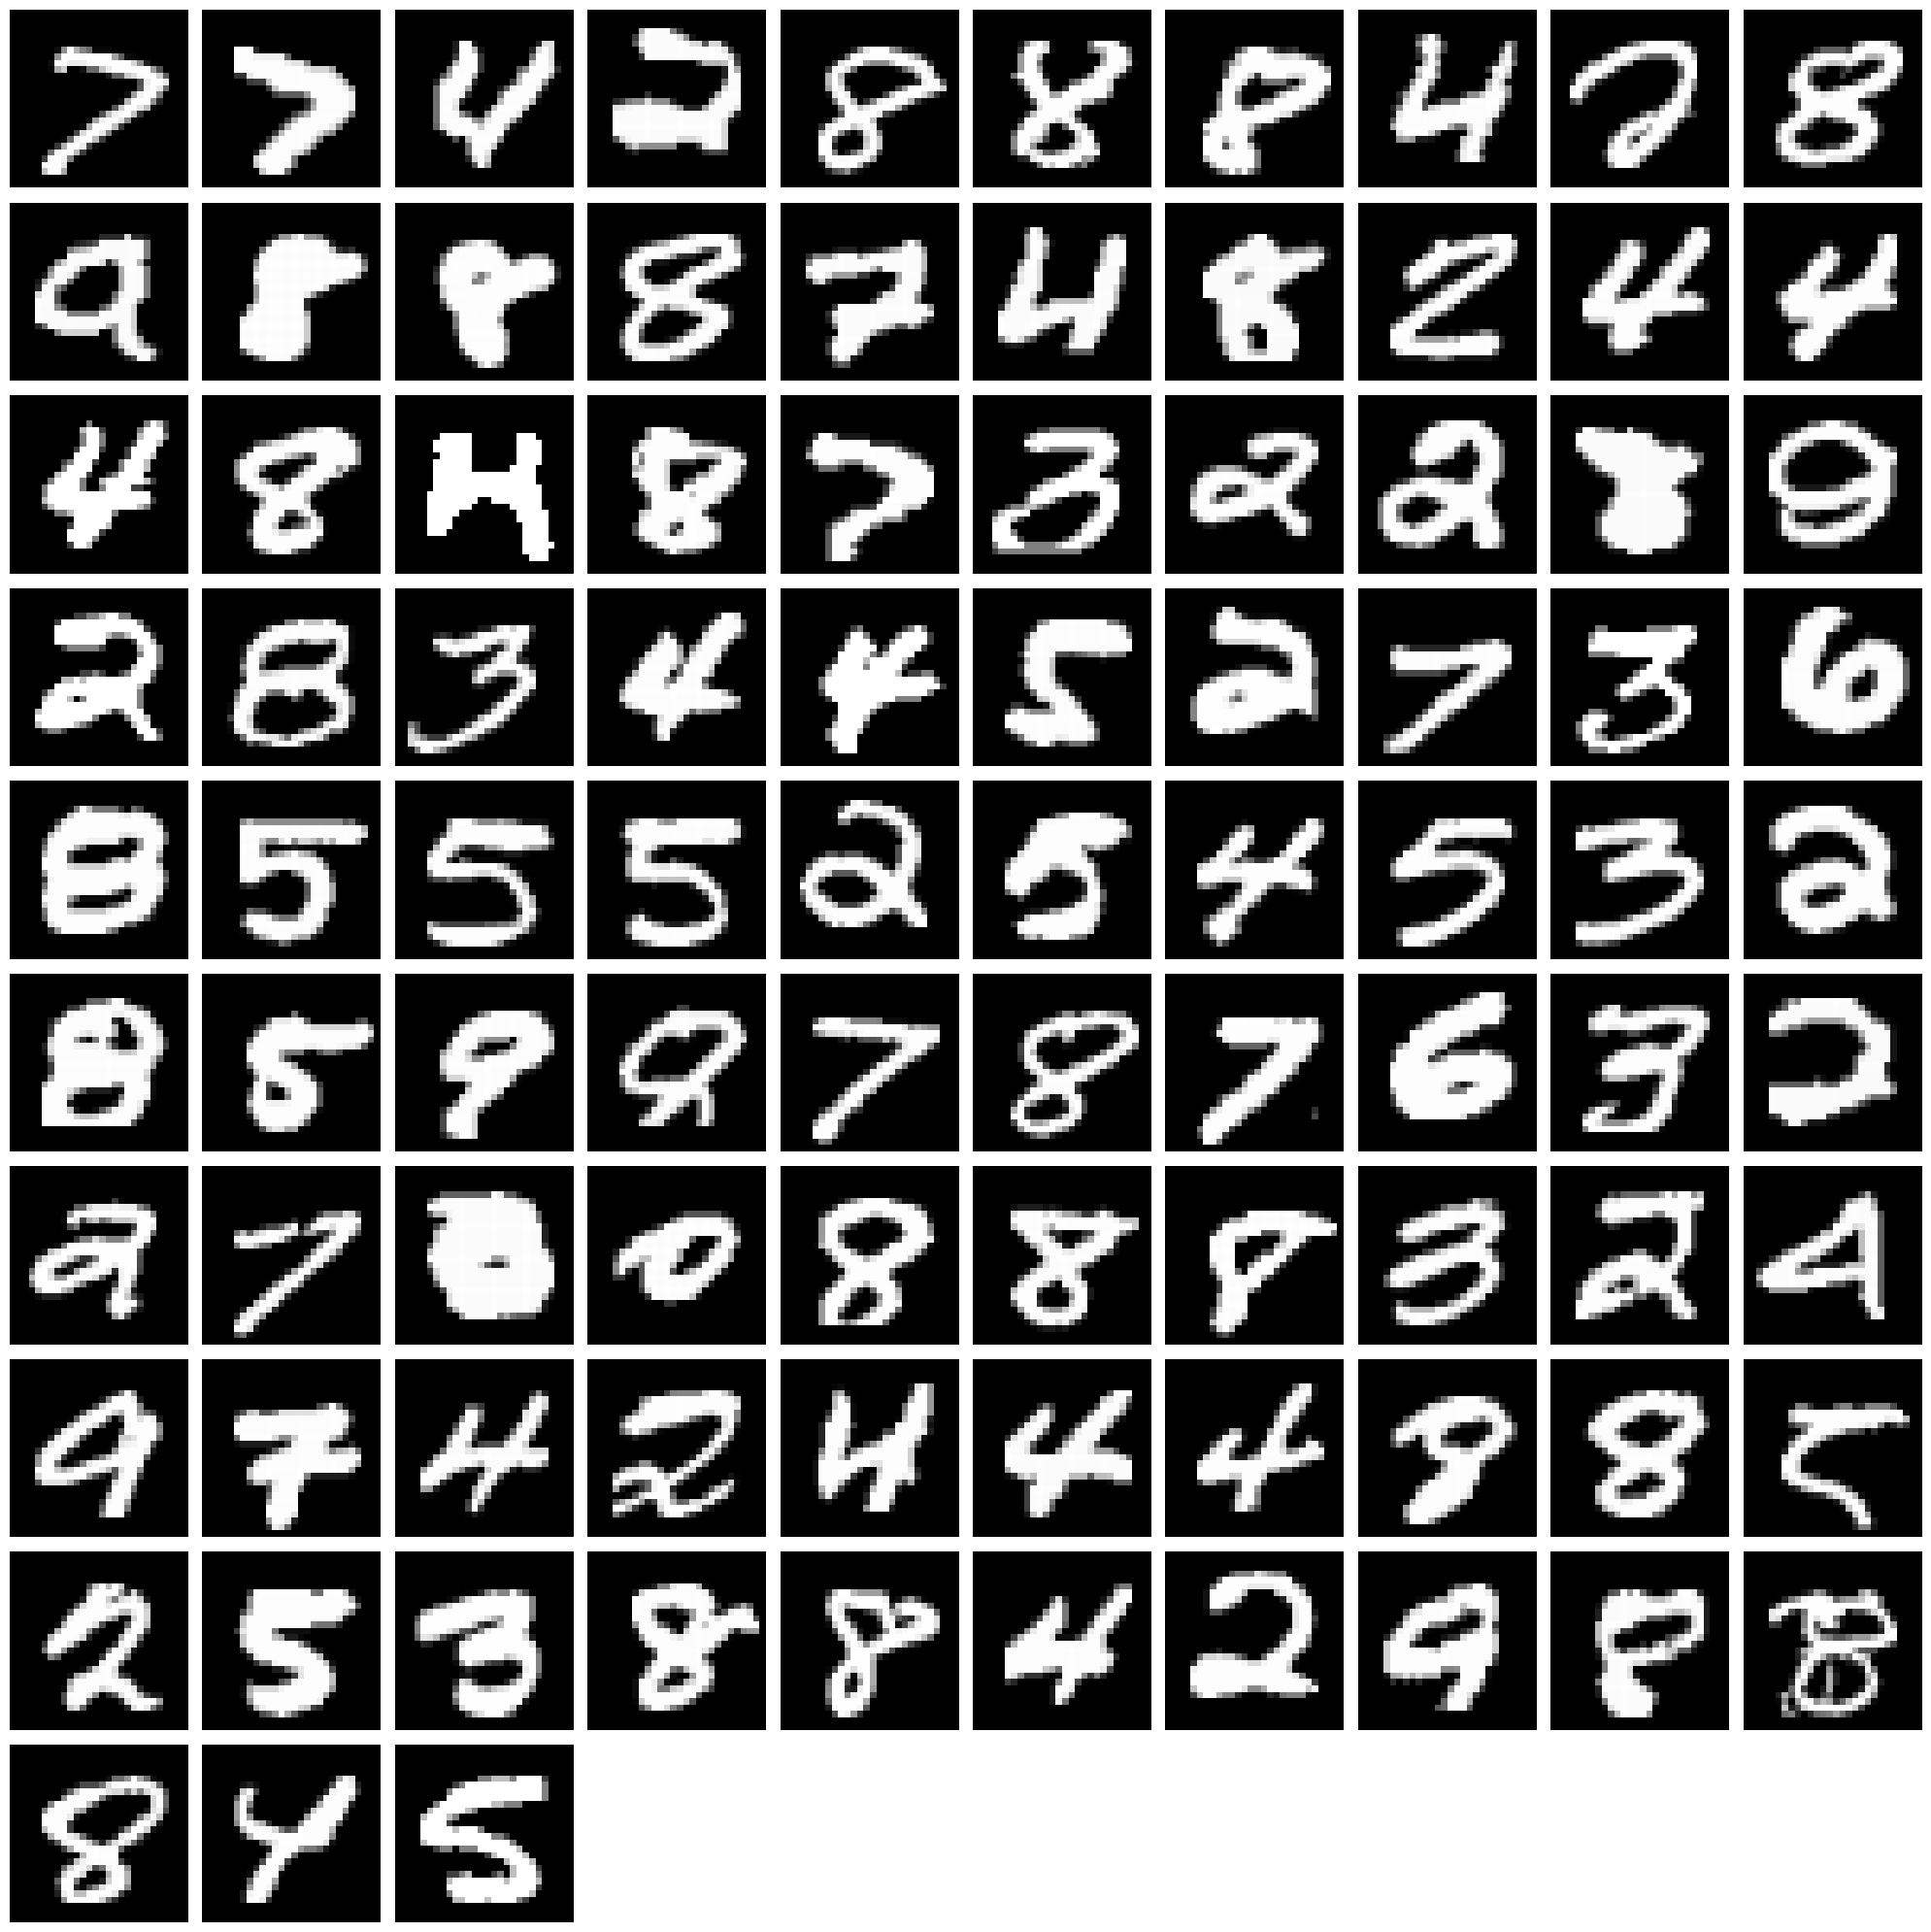

In [125]:
show_images(x_new, outliers)

In [126]:
x_idx_new = torch.tensor([e for e in x_idx_new if e not in outliers], dtype=torch.long)
x_new = x_new[x_idx_new]
dataloader = DataLoader(CustomImageDataset(x_new), batch_size=128, shuffle=True)

In [127]:
for _ in tqdm(range(10)):
    for x, idx in dataloader:

        h = model.get_submodule("encoder")(x)
        mu = h[:, :2]
        log_sigma = h[:, 2:4]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu, device=device) * sigma + mu
        pred = model.get_submodule("decoder")(z)
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='none')
        loss = ll.sum() / len(x) + kl

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


In [128]:
model.eval()

x_idx_new = torch.arange(0, len(x_new)).to(torch.long)

with torch.no_grad():
    h = model.get_submodule("encoder")(x_new)
    mu = h[:, :2]
    pred = model.get_submodule("decoder")(mu)
    ll = F.binary_cross_entropy(pred.view(-1, 28, 28), x_new, reduction='none').sum(dim=[1, 2])

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = x_idx_new[n_ll > 3]
    print(outliers.shape)

torch.Size([67])


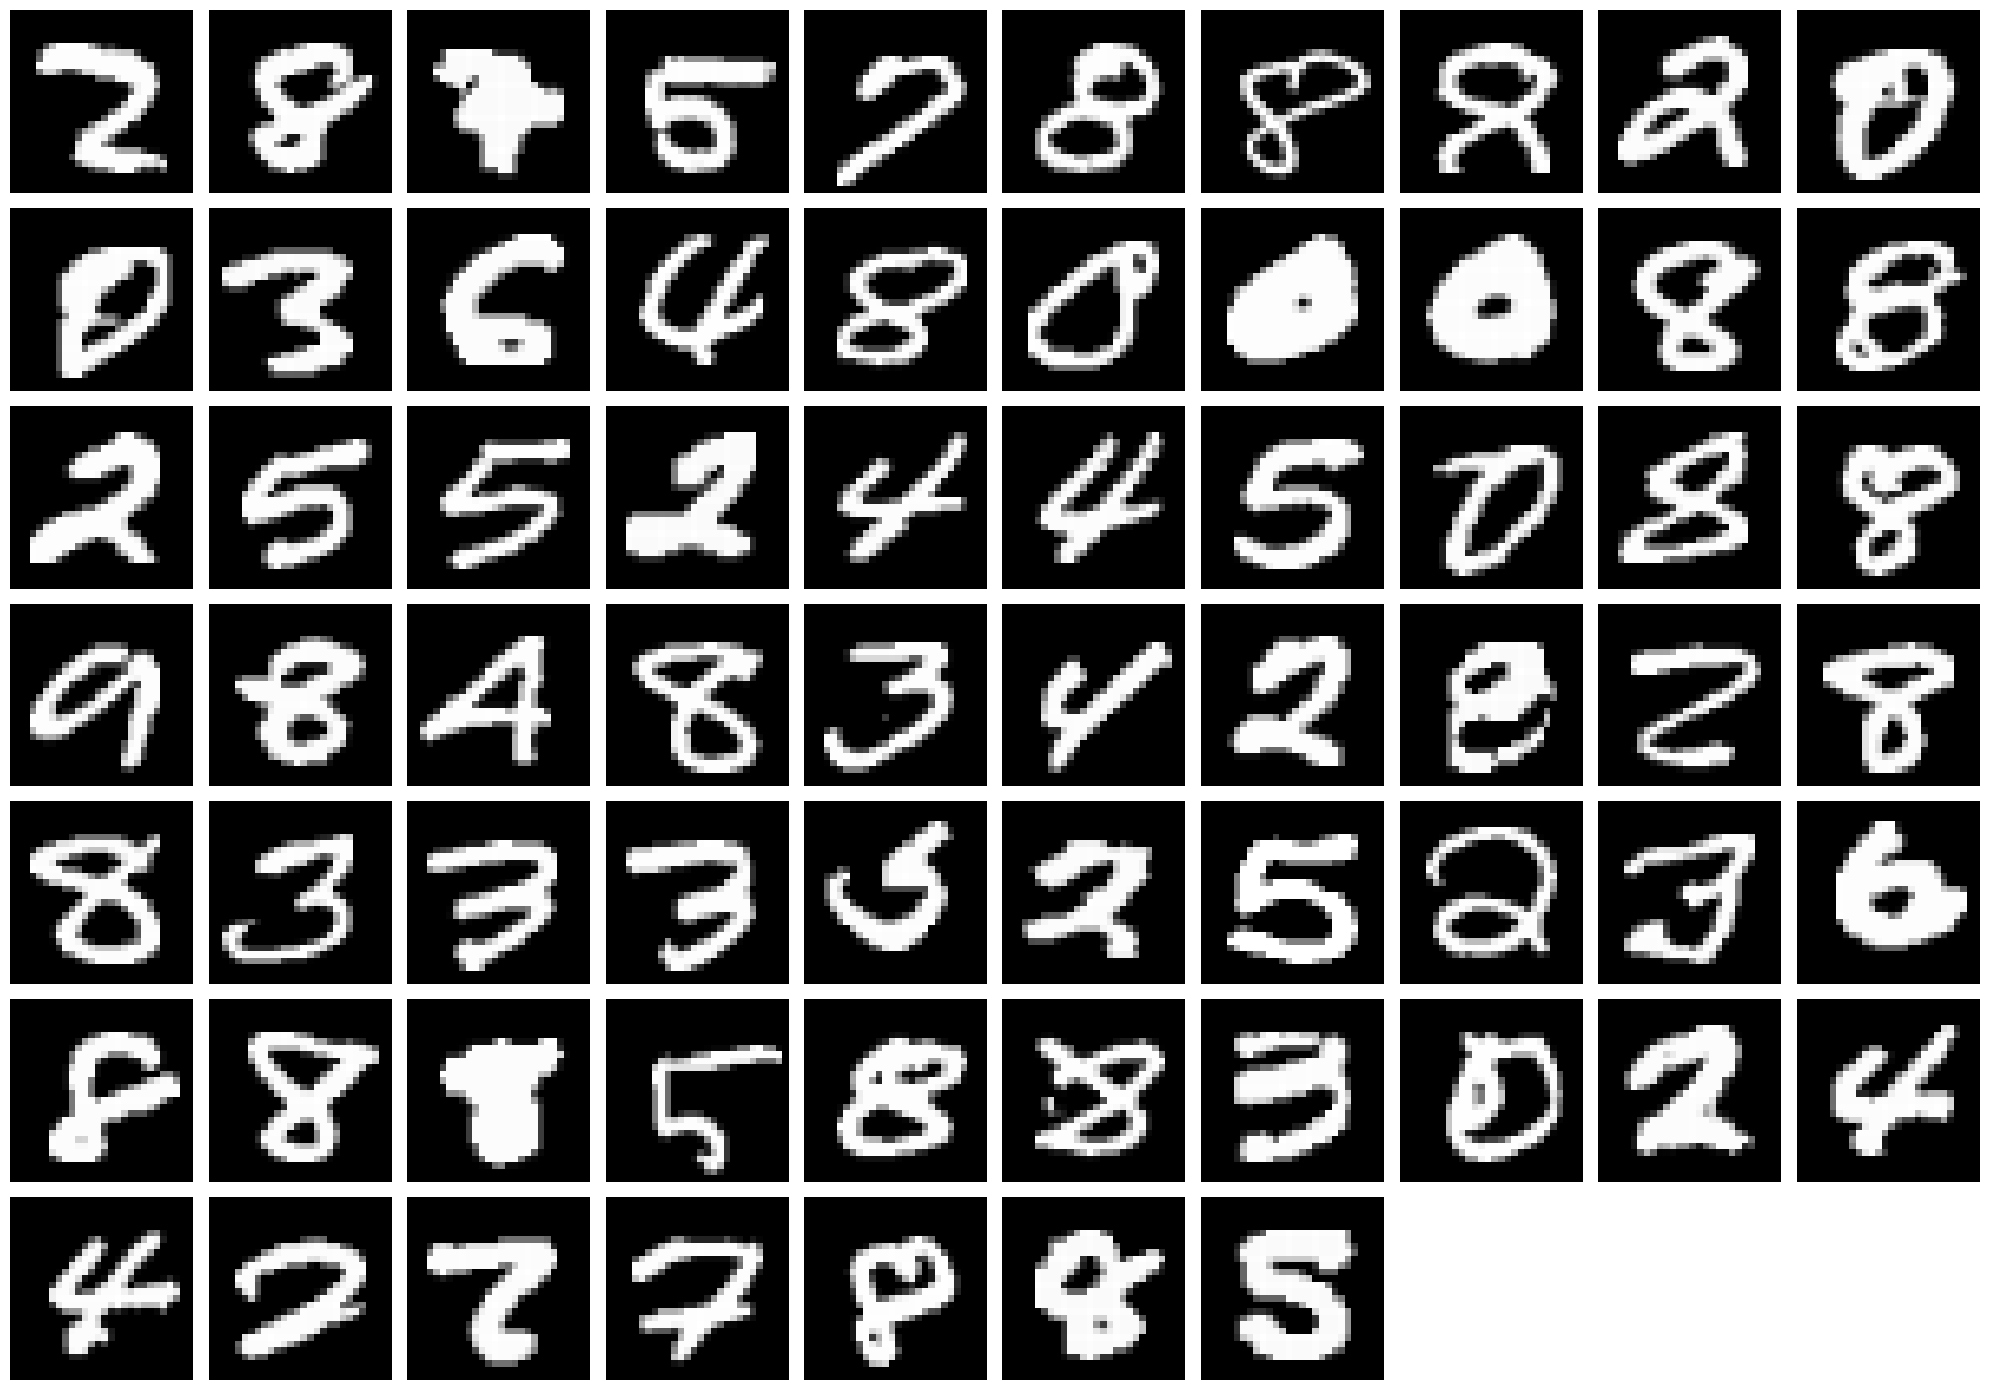

In [129]:
show_images(x_new, outliers)

In [95]:
x_idx_new = torch.tensor([e for e in x_idx_new if e not in outliers], dtype=torch.long)
x_new = x_new[x_idx_new]
dataloader = DataLoader(CustomImageDataset(x_new), batch_size=128, shuffle=True)

outliers = torch.zeros(0).to(torch.long)

for x, idx in dataloader:

    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='none').sum(dim=[1, 2, 3])
    loss = ll.sum() / len(x) + kl

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = torch.cat([outliers, idx[n_ll > 3]])

show_images(x_ori, outliers)

IndexError: index 59951 is out of bounds for dimension 0 with size 59951

In [97]:
torch.rand(10)[torch.tensor([3, 1], dtype=torch.long)]

tensor([0.8501, 0.9565])